In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

In [2]:
df = pd.read_csv('n11.csv')
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.head()

,PRICE,SELLER_GRADE,NAME,OPTICAL_DRIVE,USB,BLUETOOTH,SCREEN_SIZE,NO_OF_PROCESSOR_CORES,PROCESSOR_SPEED,DISC_TYPE,...,OPERATING_SYSTEM,SCREEN_RESOLUTION,RAM,PROCESSOR_MODEL,COLOR,PROCESSOR,GPU_CAPACITY,DISC_CAPACITY,HDMI,BRAND
0,7199,10.0,Asus X515EA-BQ945 i3-1115G4 4 GB 256 GB M.2 SS...,Yok,Var,Var,15.6,2.0,3.0,SSD,...,Freedos,1920 x 1080,4,Intel i3-1115G4,Gümüş,3.00 GHz,NaN,256,NaN,Asus
1,16499,10.0,Asus Tuf Gaming F15 FX506HC-HN409 i5-11400H 8 ...,NaN,Var,Var,15.6,6.0,2.7,SSD,...,Freedos,1920 x 1080,8,Intel i5-11400H,Siyah,6,4,512,Var,Asus
2,12767,10.0,Monster Huma H4 V5.1 i5-1235U 16 GB 512 GB SSD...,Yok,Var,Var,14.1,10.0,3.3,SSD,...,Freedos,1920 x 1080,16,Intel i5-1235U,Gümüş,10,NaN,512,Var,Monster
3,10873,10.0,Lenovo IdeaPad 5 15ALC05 82LN00R8TX R5-5500U 1...,Yok,NaN,Var,15.6,6.0,2.1,SSD,...,Freedos,1920 x 1080,16,Amd Ryzen 5-5500U,Gri,6,NaN,512,Var,Lenovo
4,20599,10.0,Monster Abra A5 V19.4.4 i5-12500H 32 GB 1 TB S...,Yok,Var,Var,15.6,12.0,3.3,SSD,...,Freedos,1920 x 1080,32,Intel i5-12500H,Siyah,12,4,1 TB,Var,Monster


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PRICE                  1000 non-null   int64  
 1   SELLER_GRADE           1000 non-null   float64
 2   NAME                   1000 non-null   object 
 3   OPTICAL_DRIVE          976 non-null    object 
 4   USB                    971 non-null    object 
 5   BLUETOOTH              972 non-null    object 
 6   SCREEN_SIZE            1000 non-null   float64
 7   NO_OF_PROCESSOR_CORES  999 non-null    float64
 8   PROCESSOR_SPEED        992 non-null    float64
 9   DISC_TYPE              1000 non-null   object 
 10  RAM_TYPE               970 non-null    object 
 11  GPU_MODEL              999 non-null    object 
 12  FINGERPRINT_READER     794 non-null    object 
 13  OPERATING_SYSTEM       1000 non-null   object 
 14  SCREEN_RESOLUTION      980 non-null    object 
 15  RAM  

In [4]:
df['SELLER_GRADE'].value_counts().sort_index(ascending = False)

10.0    910
9.9      50
9.8       6
9.7      21
9.6       4
9.5       2
9.4       3
9.2       1
9.0       1
6.8       2
Name: SELLER_GRADE, dtype: int64

In [5]:
# I will drop below 9.7 because n11 has also unofficial sellers which has low points.
df = df[df['SELLER_GRADE'] >= 9.7]
len(df)

987

In [6]:
df['DISC_CAPACITY'].value_counts()

512            368
1 TB           180
256            170
500             85
2 TB            47
1 TB + 512      45
1 TB + 256      31
250             23
1 TB + 1 TB     15
128              9
240              6
120              3
2 TB + 2 TB      2
512  + 32        1
1 TB + 128       1
2 TB + 512       1
Name: DISC_CAPACITY, dtype: int64

In [7]:
pd.options.mode.chained_assignment = None

df['DISC_CAPACITY'] = df['DISC_CAPACITY'].str.strip()
df['DISC_CAPACITY'] = df['DISC_CAPACITY'].apply(lambda x: '628' if x == '500  + 128' else x)
df['DISC_CAPACITY'] = df['DISC_CAPACITY'].apply(lambda x: '544' if x == '512  + 32' else x)
df['DISC_CAPACITY'] = df['DISC_CAPACITY'].apply(lambda x: '1536' if x == '1 TB + 512' else x)
df['DISC_CAPACITY'] = df['DISC_CAPACITY'].apply(lambda x: '1280' if x == '1 TB + 256' else x)
df['DISC_CAPACITY'] = df['DISC_CAPACITY'].apply(lambda x: '1152' if x == '1 TB + 128' else x)
df['DISC_CAPACITY'] = df['DISC_CAPACITY'].apply(lambda x: '2048' if x in ['2 TB', '1 TB + 1 TB'] else x)
df['DISC_CAPACITY'] = df['DISC_CAPACITY'].apply(lambda x: '4096' if x == '2 TB + 2 TB' else x)
df['DISC_CAPACITY'] = df['DISC_CAPACITY'].apply(lambda x: '2560' if x == '2 TB + 512' else x)
df['DISC_CAPACITY'] = df['DISC_CAPACITY'].apply(lambda x: '1024' if x == '1 TB' else x)

df['DISC_CAPACITY'].value_counts()

# Features less than 20 observations would cause deviations in our analysis.

512     368
1024    180
256     170
500      85
2048     62
1536     45
1280     31
250      23
128       9
240       6
120       3
4096      2
544       1
1152      1
2560      1
Name: DISC_CAPACITY, dtype: int64

In [8]:
disc_cap_list = []
for i in range(len(df['DISC_CAPACITY'].value_counts())):
    
    if df['DISC_CAPACITY'].value_counts()[i] >= 20:
        
        disc_cap_list.append(df['DISC_CAPACITY'].value_counts().index[i])

disc_cap_list

['512', '1024', '256', '500', '2048', '1536', '1280', '250']

In [9]:
df['DISC_CAPACITY'] = df['DISC_CAPACITY'].apply(lambda x: x if x in disc_cap_list else np.nan)
df['DISC_CAPACITY'].value_counts()

512     368
1024    180
256     170
500      85
2048     62
1536     45
1280     31
250      23
Name: DISC_CAPACITY, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PRICE                  987 non-null    int64  
 1   SELLER_GRADE           987 non-null    float64
 2   NAME                   987 non-null    object 
 3   OPTICAL_DRIVE          963 non-null    object 
 4   USB                    962 non-null    object 
 5   BLUETOOTH              963 non-null    object 
 6   SCREEN_SIZE            987 non-null    float64
 7   NO_OF_PROCESSOR_CORES  986 non-null    float64
 8   PROCESSOR_SPEED        979 non-null    float64
 9   DISC_TYPE              987 non-null    object 
 10  RAM_TYPE               959 non-null    object 
 11  GPU_MODEL              986 non-null    object 
 12  FINGERPRINT_READER     788 non-null    object 
 13  OPERATING_SYSTEM       987 non-null    object 
 14  SCREEN_RESOLUTION      971 non-null    object 
 15  RAM   

In [11]:
df['GPU_CAPACITY'] = df['GPU_CAPACITY'].apply(lambda x: '2' if x == 'Diğer' else x)
df['GPU_CAPACITY'].value_counts()

2     171
4     163
6      53
8      24
12      2
Name: GPU_CAPACITY, dtype: int64

<AxesSubplot:xlabel='GPU_CAPACITY', ylabel='PRICE'>

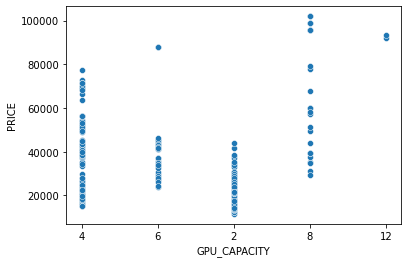

In [12]:
sns.scatterplot(data = df, x = 'GPU_CAPACITY', y = 'PRICE')

# There are lots of null values in GPU CAPACITY and as it is shown below, it is not an explanatory variable for pricing.

In [13]:
df['OPTICAL_DRIVE'].value_counts()
# Not a classifier.

Yok    962
Var      1
Name: OPTICAL_DRIVE, dtype: int64

In [14]:
df['USB'].value_counts()

Var    923
Yok     39
Name: USB, dtype: int64

In [15]:
df['BLUETOOTH'].value_counts()
# Not a classifier.

Var    963
Name: BLUETOOTH, dtype: int64

In [16]:
df['SCREEN_SIZE'].value_counts()

15.6    615
14.0    245
16.0     42
17.3     29
16.1     24
14.1     12
13.3      8
17.0      4
13.6      2
14.5      2
13.0      2
12.4      1
13.4      1
Name: SCREEN_SIZE, dtype: int64

In [17]:
df['PROCESSOR_SPEED'].value_counts()

2.8    192
2.4    178
3.5    104
3.3     98
1.8     54
2.3     50
3.0     48
3.4     36
2.9     33
2.6     31
3.2     28
2.1     20
2.5     14
1.1     14
2.7     13
1.0     11
1.6     10
2.0     10
3.7      8
1.3      5
1.2      5
3.8      5
3.1      3
3.6      3
2.2      2
4.7      2
4.1      1
1.7      1
Name: PROCESSOR_SPEED, dtype: int64

In [18]:
processor_speed_list = []
for i in range(len(df['PROCESSOR_SPEED'].value_counts())):
    
    if df['PROCESSOR_SPEED'].value_counts().values[i] >= 20:
        
        processor_speed_list.append(df['PROCESSOR_SPEED'].value_counts().index[i])

processor_speed_list

[2.8, 2.4, 3.5, 3.3, 1.8, 2.3, 3.0, 3.4, 2.9, 2.6, 3.2, 2.1]

In [19]:
df['PROCESSOR_SPEED'] = df['PROCESSOR_SPEED'].apply(lambda x: x if x in processor_speed_list else np.nan)
df['PROCESSOR_SPEED'].value_counts()

2.8    192
2.4    178
3.5    104
3.3     98
1.8     54
2.3     50
3.0     48
3.4     36
2.9     33
2.6     31
3.2     28
2.1     20
Name: PROCESSOR_SPEED, dtype: int64

In [20]:
df['NO_OF_PROCESSOR_CORES'].value_counts()

4.0     464
8.0     125
10.0    115
6.0      94
12.0     71
2.0      65
14.0     49
16.0      3
Name: NO_OF_PROCESSOR_CORES, dtype: int64

In [21]:
no_of_cores_list = []
for i in range(len(df['NO_OF_PROCESSOR_CORES'].value_counts())):
    
    
    if df['NO_OF_PROCESSOR_CORES'].value_counts().values[i] >= 20:
        
        no_of_cores_list.append(df['NO_OF_PROCESSOR_CORES'].value_counts().index[i])

no_of_cores_list

[4.0, 8.0, 10.0, 6.0, 12.0, 2.0, 14.0]

In [22]:
df['NO_OF_PROCESSOR_CORES'] = df['NO_OF_PROCESSOR_CORES'].apply(lambda x: x if x in no_of_cores_list else np.nan)
df['NO_OF_PROCESSOR_CORES'].value_counts()

4.0     464
8.0     125
10.0    115
6.0      94
12.0     71
2.0      65
14.0     49
Name: NO_OF_PROCESSOR_CORES, dtype: int64

<AxesSubplot:xlabel='NO_OF_PROCESSOR_CORES', ylabel='PRICE'>

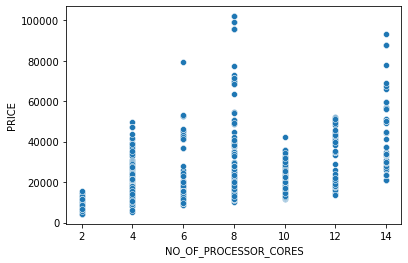

In [23]:
sns.scatterplot(data = df, x = 'NO_OF_PROCESSOR_CORES', y = 'PRICE')

In [24]:
df['DISC_TYPE'].value_counts()

SSD          942
HDD - SSD     41
HDD            4
Name: DISC_TYPE, dtype: int64

<AxesSubplot:xlabel='DISC_TYPE', ylabel='PRICE'>

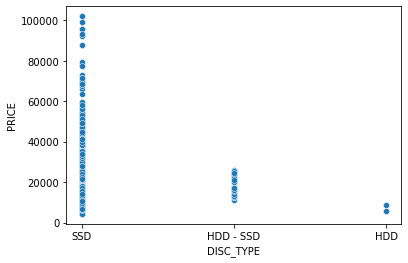

In [25]:
sns.scatterplot(data = df, x = 'DISC_TYPE', y = 'PRICE')
# Not explanatory.

In [26]:
df['RAM_TYPE'].value_counts()

DDR4       886
DDR5        64
LPDDR4       4
LPDDR4X      2
LPDDR5       2
DDR3         1
Name: RAM_TYPE, dtype: int64

<AxesSubplot:xlabel='RAM_TYPE', ylabel='PRICE'>

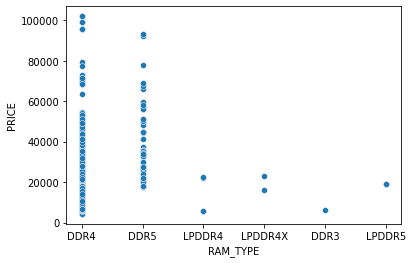

In [27]:
sns.scatterplot(data = df, x = 'RAM_TYPE', y = 'PRICE')
# Not explanatory.

In [28]:
df['GPU_MODEL'].value_counts()

Paylaşımlı     564
Paylaşımsız    422
Name: GPU_MODEL, dtype: int64

<AxesSubplot:xlabel='PROCESSOR_SPEED', ylabel='PRICE'>

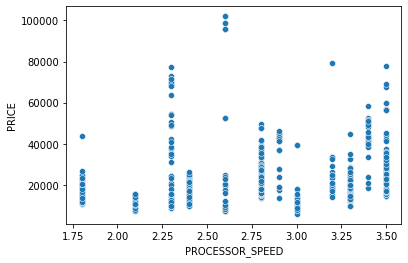

In [29]:
sns.scatterplot(data = df, x = 'PROCESSOR_SPEED', y = 'PRICE')

In [30]:
df['OPERATING_SYSTEM'].value_counts()
# Freedos means no operating system.

Freedos            434
Windows 10 Pro     169
Windows 11 Pro     133
Windows 11 Home    121
Windows 10 Home     80
Ubuntu              25
Macos                8
Linux                8
Yok (Free Dos)       4
Windows 10           4
Free Dos             1
Name: OPERATING_SYSTEM, dtype: int64

In [31]:
df['SCREEN_RESOLUTION'].value_counts()
# Less than 10 samples for a particular category would only cause confusion for the analysis.

 1920 x 1080    821
 1920 x 1200     75
 2560 x 1440     36
 1366 x 768      19
 2560 x 1600      7
 3840 x 2160      4
 3840 x 2400      3
 3024 x 1964      2
 2880 x 1800      1
 1920 x 1280      1
 3456 x 2160      1
 2560 x 1664      1
Name: SCREEN_RESOLUTION, dtype: int64

In [32]:
screen_res_list = []
for i in range(len(df['SCREEN_RESOLUTION'].value_counts())):
    
    
    if df['SCREEN_RESOLUTION'].value_counts().values[i] >= 19:
        
        screen_res_list.append(df['SCREEN_RESOLUTION'].value_counts().index[i])

screen_res_list

[' 1920 x 1080', ' 1920 x 1200', ' 2560 x 1440', ' 1366 x 768']

In [33]:
df['SCREEN_RESOLUTION'] = df['SCREEN_RESOLUTION'].apply(lambda x: x if x in screen_res_list else np.nan)
df['SCREEN_RESOLUTION'].value_counts()

 1920 x 1080    821
 1920 x 1200     75
 2560 x 1440     36
 1366 x 768      19
Name: SCREEN_RESOLUTION, dtype: int64

In [34]:
df['RAM'].value_counts()

16     342
8      235
32     164
24      44
4       41
20      35
12      34
40      33
64      27
48      19
36      12
128      1
Name: RAM, dtype: int64

In [35]:
ram_list = []
for i in range(len(df['RAM'].value_counts())):
    
    
    if df['RAM'].value_counts().values[i] >= 19:
        
        ram_list.append(df['RAM'].value_counts().index[i])

ram_list

[16, 8, 32, 24, 4, 20, 12, 40, 64, 48]

In [36]:
df['RAM'] = df['RAM'].apply(lambda x: x if x in ram_list else np.nan)
df['RAM'].value_counts()

16.0    342
8.0     235
32.0    164
24.0     44
4.0      41
20.0     35
12.0     34
40.0     33
64.0     27
48.0     19
Name: RAM, dtype: int64

<AxesSubplot:xlabel='RAM', ylabel='PRICE'>

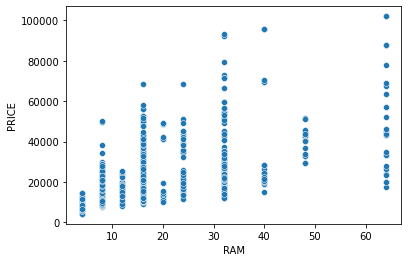

In [37]:
sns.scatterplot(data = df, x = 'RAM', y = 'PRICE')

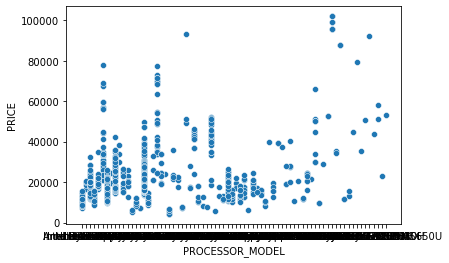

In [38]:
sns.scatterplot(data = df, x = 'PROCESSOR_MODEL', y = 'PRICE')
plt.show()
# Not explanatory.

In [39]:
df['HDMI'].value_counts()
# Not explanatory.

Var    932
Yok     21
Name: HDMI, dtype: int64

In [40]:
df['BRAND'].value_counts()

Lenovo        532
HP            137
Dell          130
Asus           64
Monster        38
Casper         28
Acer           23
Apple           8
Huawei          6
Msi             4
Hometech        4
Game Garaj      4
Gigabyte        3
Everest         3
I-Life          2
Toshiba         1
Name: BRAND, dtype: int64

In [41]:
brand_list = []
for i in range(len(df['BRAND'].value_counts())):
    
    
    if df['BRAND'].value_counts().values[i] >= 19:
        
        brand_list.append(df['BRAND'].value_counts().index[i])

brand_list

['Lenovo', 'HP', 'Dell', 'Asus', 'Monster', 'Casper', 'Acer']

In [42]:
df['BRAND'] = df['BRAND'].apply(lambda x: x if x in brand_list else np.nan)
df['BRAND'].value_counts()

Lenovo     532
HP         137
Dell       130
Asus        64
Monster     38
Casper      28
Acer        23
Name: BRAND, dtype: int64

In [43]:
regression = df[['PRICE','NO_OF_PROCESSOR_CORES','PROCESSOR_SPEED','GPU_MODEL','OPERATING_SYSTEM',
                     'DISC_CAPACITY','SCREEN_RESOLUTION','RAM','BRAND']]
regression.head()

,PRICE,NO_OF_PROCESSOR_CORES,PROCESSOR_SPEED,GPU_MODEL,OPERATING_SYSTEM,DISC_CAPACITY,SCREEN_RESOLUTION,RAM,BRAND
0,7199,2.0,3.0,Paylaşımlı,Freedos,256,1920 x 1080,4.0,Asus
1,16499,6.0,NaN,Paylaşımsız,Freedos,512,1920 x 1080,8.0,Asus
2,12767,10.0,3.3,Paylaşımlı,Freedos,512,1920 x 1080,16.0,Monster
3,10873,6.0,2.1,Paylaşımlı,Freedos,512,1920 x 1080,16.0,Lenovo
4,20599,12.0,3.3,Paylaşımsız,Freedos,1024,1920 x 1080,32.0,Monster


In [44]:
regression.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PRICE                  987 non-null    int64  
 1   NO_OF_PROCESSOR_CORES  983 non-null    float64
 2   PROCESSOR_SPEED        872 non-null    float64
 3   GPU_MODEL              986 non-null    object 
 4   OPERATING_SYSTEM       987 non-null    object 
 5   DISC_CAPACITY          964 non-null    object 
 6   SCREEN_RESOLUTION      951 non-null    object 
 7   RAM                    974 non-null    float64
 8   BRAND                  952 non-null    object 
dtypes: float64(3), int64(1), object(5)
memory usage: 77.1+ KB


In [45]:
regression.dropna(axis = 0, inplace = True)
regression.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 808 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PRICE                  808 non-null    int64  
 1   NO_OF_PROCESSOR_CORES  808 non-null    float64
 2   PROCESSOR_SPEED        808 non-null    float64
 3   GPU_MODEL              808 non-null    object 
 4   OPERATING_SYSTEM       808 non-null    object 
 5   DISC_CAPACITY          808 non-null    object 
 6   SCREEN_RESOLUTION      808 non-null    object 
 7   RAM                    808 non-null    float64
 8   BRAND                  808 non-null    object 
dtypes: float64(3), int64(1), object(5)
memory usage: 63.1+ KB


In [46]:
# There are outliers in terms of laptop prices. They should be eliminated.

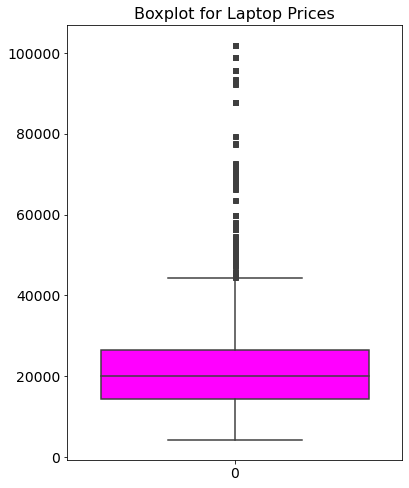

In [47]:
fig, axes = plt.subplots(figsize = (6,8)) 

p = sns.boxplot(data = df['PRICE'], flierprops={'marker': 's'}, boxprops={'facecolor': 'magenta'})
plt.tick_params(axis = 'both', labelsize = 14)
p.set_title('Boxplot for Laptop Prices', fontsize = 16)

plt.show()
# np.log(price)

In [48]:
def detect_outliers(data, iqr_multiplier = 1.5):
    
    """
    Boxplots shows the outliers, this function will help us detect those points.
    """
    
    lower_quartile = np.quantile(data, 0.25)
    upper_quartile = np.quantile(data, 0.75)
    
    iqr = upper_quartile - lower_quartile
    
    lower_whisker = lower_quartile - iqr * iqr_multiplier
    upper_whisker = upper_quartile + iqr * iqr_multiplier
    
    print("Lower Whisker : ", data[data >= lower_whisker].min())
    print("Upper Whisker : ", data[data <= upper_whisker].max())    

In [49]:
detect_outliers(regression['PRICE'])

Lower Whisker :  5819
Upper Whisker :  43654


In [50]:
regression = regression[regression['PRICE'] < 43654]
regression.reset_index(drop = True, inplace = True)
len(regression)
# 59 rows are eliminated

749

In [51]:
# Encoding part

In [52]:
regression['OPERATING_SYSTEM'] = regression['OPERATING_SYSTEM'].\
                                    apply(lambda x: 0 if x in ['Freedos', 'Yok (Free Dos)', 'Free Dos'] else 1)
regression['OPERATING_SYSTEM'].value_counts()

1    395
0    354
Name: OPERATING_SYSTEM, dtype: int64

In [53]:
regression['GPU_MODEL'] = regression['GPU_MODEL'].apply(lambda x: 1 if x == 'Paylaşımsız' else 0)
regression['GPU_MODEL'].value_counts()

0    458
1    291
Name: GPU_MODEL, dtype: int64

In [54]:
regression.isna().sum()

PRICE                    0
NO_OF_PROCESSOR_CORES    0
PROCESSOR_SPEED          0
GPU_MODEL                0
OPERATING_SYSTEM         0
DISC_CAPACITY            0
SCREEN_RESOLUTION        0
RAM                      0
BRAND                    0
dtype: int64

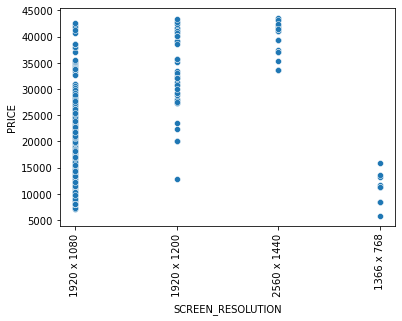

In [55]:
p = sns.scatterplot(data = regression, x = 'SCREEN_RESOLUTION', y = 'PRICE')
p.tick_params(axis = 'x', rotation = 90)

# A good identifier.

In [56]:
screen_res = pd.get_dummies(regression['SCREEN_RESOLUTION'], drop_first = True)
brand = pd.get_dummies(regression['BRAND'], drop_first = True)
regression = regression.join(screen_res)
regression = regression.join(brand)
regression['DISC_CAPACITY'] = regression['DISC_CAPACITY'].astype('int')
regression.drop(['BRAND','SCREEN_RESOLUTION'], axis = 1, inplace = True)

regression.head()

,PRICE,NO_OF_PROCESSOR_CORES,PROCESSOR_SPEED,GPU_MODEL,OPERATING_SYSTEM,DISC_CAPACITY,RAM,1920 x 1080,1920 x 1200,2560 x 1440,Asus,Casper,Dell,HP,Lenovo,Monster
0,7199,2.0,3.0,0,0,256,4.0,1,0,0,1,0,0,0,0,0
1,12767,10.0,3.3,0,0,512,16.0,1,0,0,0,0,0,0,0,1
2,10873,6.0,2.1,0,0,512,16.0,1,0,0,0,0,0,0,1,0
3,20599,12.0,3.3,1,0,1024,32.0,1,0,0,0,0,0,0,0,1
4,29759,14.0,3.5,1,0,1024,32.0,1,0,0,0,0,0,0,0,1


In [57]:
regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 749 entries, 0 to 748
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PRICE                  749 non-null    int64  
 1   NO_OF_PROCESSOR_CORES  749 non-null    float64
 2   PROCESSOR_SPEED        749 non-null    float64
 3   GPU_MODEL              749 non-null    int64  
 4   OPERATING_SYSTEM       749 non-null    int64  
 5   DISC_CAPACITY          749 non-null    int32  
 6   RAM                    749 non-null    float64
 7    1920 x 1080           749 non-null    uint8  
 8    1920 x 1200           749 non-null    uint8  
 9    2560 x 1440           749 non-null    uint8  
 10  Asus                   749 non-null    uint8  
 11  Casper                 749 non-null    uint8  
 12  Dell                   749 non-null    uint8  
 13  HP                     749 non-null    uint8  
 14  Lenovo                 749 non-null    uint8  
 15  Monste

In [58]:
x = regression.drop(['PRICE'], axis = 1)
y = regression['PRICE']

x_constant = sm.add_constant(x)
model = sm.OLS(y, x_constant)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     149.3
Date:                Tue, 21 Mar 2023   Prob (F-statistic):          6.68e-211
Time:                        17:50:15   Log-Likelihood:                -7286.5
No. Observations:                 749   AIC:                         1.461e+04
Df Residuals:                     733   BIC:                         1.468e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -4516.5214   1906.786     -2.369      0.018   -8259.934    -773.109
NO_OF_PROCESSOR_CORES   481.2839     66.750      7.210      0.000     350.239     612.328
PROCESSOR_SPEED        2129.1380    395.690      5.381      0.000    1352.317    2905.959
GPU_MODEL              5117.2280    342.445     14.943      0.000    4444.939    5789.517
OPERATING_SYSTEM       4306.2839    324.551     13.268      0.000    3669.125    4943.443
DISC_CAPACITY             2.2878      0.327      6.989      0.000       1.645       2.930
RAM                     156.3760     14.690     10.645      0.000     127.537     185.215
 1920 x 1080           2880.6539   1355.522      2.125      0.034     219.486    5541.822
 1920 x 1200           1.119e+04   1577.746      7.095      0.000    8096.658    1.43e+04
 2560 x 1440           1.709e+04   1614.110     10.590      0.000    1.39e+04    2.03e+04
Asus                   3167.0872   1184.475      2.674      0.008     841.720    5492.455
Casper                 1053.7007   1297.107      0.812      0.417   -1492.787    3600.189
Dell                   2675.8235   1053.476      2.540      0.011     607.633    4744.014
HP                     1488.4616   1029.777      1.445      0.149    -533.201    3510.125
Lenovo                 5171.0587    988.280      5.232      0.000    3230.863    7111.255
Monster                 114.6628   1229.027      0.093      0.926   -2298.170    2527.496
==============================================================================
Omnibus:                      121.903   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              255.170
Skew:                           0.917   Prob(JB):                     3.90e-56
Kurtosis:                       5.193   Cond. No.                     1.64e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.64e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [59]:
# Looking at the p-values, everything seems fine.

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

In [61]:
# Train-Test
X = regression.drop(['PRICE'], axis = 1)
y = regression['PRICE']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test", y_test.shape)

x_train: (599, 15)
y_train: (599,)
x_test: (150, 15)
y_test (150,)


In [62]:
# Linear Regression

In [63]:
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Only the training set is transformed by using .fit_transform(), because we are fitting the train data only.

reg = LinearRegression()
reg.fit(x_train_scaled, y_train)
reg.score(x_test_scaled, y_test)

0.7915096790770548

In [64]:
steps = [
    ('standardize', StandardScaler()),
    ('reg', LinearRegression())]

pipe = Pipeline(steps)
pipe.fit(x_train,y_train)
pipe.score(x_test,y_test)

0.7915096790770548

In [65]:
# Polynomial Regression

Polynomial Degree: 1, Score: 0.792
Polynomial Degree: 2, Score: 0.814
Polynomial Degree: 3, Score: -1293478.956


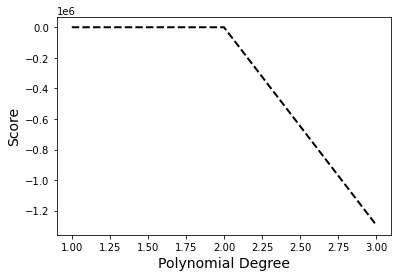

In [66]:
scores = []
poly_degrees = 3

for degree in range(1, poly_degrees+1):
    
    poly = PolynomialFeatures(degree = degree)
    
    x_train_poly = poly.fit_transform(x_train.values)
    x_test_poly = poly.transform(x_test.values)
    
    lm_poly = LinearRegression()

    lm_poly.fit(x_train_poly, y_train)

    scores.append(lm_poly.score(x_test_poly, y_test))

# Sonuçları inceleme    
for degree, score in enumerate(scores):
    print(f"Polynomial Degree: {degree+1}, Score: {score:.3f}")

p = sns.lineplot(x = range(1,4), y = scores, linewidth = 2, linestyle = '--', color = 'black')
p.set_xlabel('Polynomial Degree', fontsize = 14)
p.set_ylabel('Score', fontsize = 14)

plt.show()

In [67]:
# Lasso Regression

Maximum Lasso Score : 0.7948276470592263
Alpha value for obtaining that score : 21.62


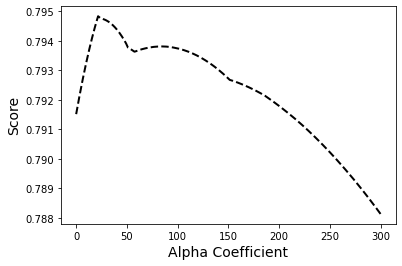

In [68]:
alpha_list = [*np.linspace(0.001,300,1000)]
scores = []
for iterate_alpha in alpha_list:

    steps = [
        ('standardize', StandardScaler()),
        ('lasso', Lasso(alpha = iterate_alpha))]
    
    pipe = Pipeline(steps)
    pipe.fit(x_train,y_train)
    score = pipe.score(x_test,y_test)
    scores.append(score)

p = sns.lineplot(x = alpha_list, y = scores, linewidth = 2, linestyle = '--', color = 'black')
p.set_xlabel('Alpha Coefficient', fontsize = 14)
p.set_ylabel('Score', fontsize = 14)

print('Maximum Lasso Score :', np.max(scores))
print('Alpha value for obtaining that score :', round(alpha_list[np.argmax(scores)], 2))

In [69]:
# Ridge Regression

Maximum Ridge Score : 0.7941701347077195
Alpha value for obtaining that score : 19.22


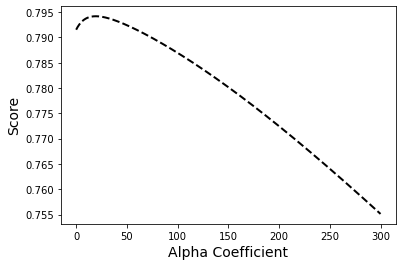

In [70]:
alpha_list = [*np.linspace(0.001,300,1000)]
scores = []
for iterate_alpha in alpha_list:

    steps = [
        ('standardize', StandardScaler()),
        ('ridge', Ridge(alpha = iterate_alpha))]
    
    pipe = Pipeline(steps)
    pipe.fit(x_train,y_train)
    score = pipe.score(x_test,y_test)
    scores.append(score)

p = sns.lineplot(x = alpha_list, y = scores, linewidth = 2, linestyle = '--', color = 'black')
p.set_xlabel('Alpha Coefficient', fontsize = 14)
p.set_ylabel('Score', fontsize = 14)

print('Maximum Ridge Score :', np.max(scores))
print('Alpha value for obtaining that score :', round(alpha_list[np.argmax(scores)], 2))

In [71]:
polynomial = PolynomialFeatures(degree = 2)
    
x_train_poly = polynomial.fit_transform(x_train)
x_test_poly = polynomial.transform(x_test)

model = LinearRegression()

model.fit(x_train_poly, y_train)
print('R^2 :',model.score(x_test_poly, y_test))

R^2 : 0.8139341800779194


In [72]:
d = {'Actual Values': y_test.values, 'Predictions': model.predict(x_test_poly)}
df_plot = pd.DataFrame(data = d)
df_plot['Error'] = np.abs(df_plot['Actual Values'] - df_plot['Predictions'])
df_plot['Error %'] = df_plot['Error'] * 100 / df_plot['Actual Values']
df_plot.head()

,Actual Values,Predictions,Error,Error %
0,43276,42281.153971,994.846029,2.298840
1,27964,21167.512078,6796.487922,24.304420
2,29299,24270.855239,5028.144761,17.161489
3,13587,17582.914420,3995.914420,29.409836
4,43341,43358.537033,17.537033,0.040463


In [73]:
df_plot[df_plot['Error %'] > 20]['Actual Values'].describe()
# From here we can see that our regression model came short predicting 'low priced laptops'.
# However, looking at the overall, 0.814 is a good score.

count       46.000000
mean     17265.326087
std       8116.653720
min       7999.000000
25%      10203.250000
50%      16004.500000
75%      21817.750000
max      41223.000000
Name: Actual Values, dtype: float64

In [74]:
# Lets define a function which uses my linear regression model to predict laptop prices with specific features.

def predict_prices(array):
    
    """
    
    This function takes an array with 16 indexes.
    Those indexes represents the laptop properties with a given order.
    No of processor cores, Processor speed, Gpu model, Operating system, Disc Capacity, Ram,
    
    'Next three indexes are dummies for Screen Resolution'
    1920 x 1080, 1920 x 1200, 2560 x 1440, enter 1 for your screen resolution and the rest is 0, if 
    the screen resolution is 1366 x 768, then enter 0 for all screen resolutions. 
    
    'Next six indexes are dummies for Brand'
    Asus, Casper, Dell, HP, Lenovo, Monster, enter 1 for your brand and rest is 0, if the brand
    is Acer, then enter 0 for all brands.
    
    This function takes an array of (15,1) shape as input.
    
    """
    polynomial = PolynomialFeatures(degree = 2)
    
    x_train_poly = polynomial.fit_transform(x_train.values)
    array_transposed = array.transpose()
    array_transposed_poly = polynomial.transform(array_transposed)
    
    model = LinearRegression()
    model.fit(x_train_poly, y_train)
    
    return model.predict(array_transposed_poly)[0]

In [75]:
# Lets predict a laptop with 8 processor cores, 3.3 GHz of processor speed with unshared graphic card, Windows downloaded,
# Disc capacity of 512 GB, 32 GB Ram, Screen resolution of 2560 x 1440.
# And assume this laptops brand is Lenovo

array = np.array([8, 3.3, 1, 1, 512, 32, 0, 0, 1, 0, 0, 0, 0, 1, 0]).reshape(-1,1)
array.shape

(15, 1)

In [1]:
from IPython.display import IFrame
IFrame("lenovo_price.pdf", width=600, height=300)

In [77]:
predict_prices(array)

# My model predicts 34157 TL for a product originally 34999 TL in a different website.

34157.151216719285